# Training vs validation loss

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/3.train-test-diabetes.ipynb)

By [Terence Parr](https://explained.ai).

This notebook explores how to use a validation set to estimate how well a model generalizes from its training data to unknown test vectors. We will see that deep learning models often have so many parameters that we can drive training loss to zero, but unfortunately the validation loss grows as the model overfits. We will also compare how deep learning performs compared to a random forest model as a baseline.  Instead of the cars data set, we will use the [diabetes data set](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) loaded via sklearn.

## Support code

In [52]:
import os
import sys
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [53]:
def plot_history(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")

## Load diabetes data set

From [sklearn diabetes data set](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset):
"<i>Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.</i>"

So, the goal is to predict disease progression based upon all of these features.

In [54]:
d = load_diabetes()
len(d.data)

442

In [55]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

Any sufficiently powerful model is able to effectively drive down the training loss (error). What we really care about, though, is how well the model generalizes. That means we have to look at the validation or test error, computed from records the model was not trained on. (We'll use "test" as shorthand for "validation" but technically they are not the same.)  For non-time-sensitive data sets, we can simply randomize and hold out 20% as our validation set:

In [56]:
np.random.seed(1) # set a random seed for consistency across runs
n = len(df)
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) # hold out 20%

Let's also make sure to normalize the data to make training easier:

In [57]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

When building machine learning models, it's always important to ask how good your model is. One of the best ways is to choose a baseline model, such as a random forest or a linear regression model, and compare your new model to make sure it can beat the old model.  Random forests are easy to use, understand, and train so they are a good baseline.  Don't worry about the details of using sklearn to train the random forest regressor, just assume it is a powerful and efficient model. Training the model is as simple as calling `fit()`:

In [58]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))

RandomForestRegressor(n_estimators=500)

To evaluate our models, let's compute the mean squared error (MSE) for both training and validation sets:

In [59]:
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred_test = rf.predict(X_test)
mse_test = np.mean((y_pred_test - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 443.77 validation MSE 3745.30


#### Exercise

Why is the validation error much larger than the training error?

<details>
<summary>Solution</summary>
    Because the model was trained on the training set, one would expect it to generally perform better on it than any other data set.  The more the validation error diverges from the training error, the less general you should assume your model is.
</details>

## Train network with increasingly sophisticated training method

Ok, so now we have a baseline and an understanding of how well a decent model performs on this data set. Let's see if we can beat that baseline with a neural network. First we will see how easy it is to drive the training error down and then show how the validation error is not usually very good in that case.  We will finish by considering ways to get better validation errors, which means more general models.

### Most basic network training

A basic training loop for a neural network model simply measures and tracks the training loss or error/metric. (In this case, our loss and metric are the same.)  The following function embodies such a training loop:

In [60]:
def train0(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()

To use this method, we have to convert the training and validation data sets to pytorch tensors from numpy (they our already normalized):

In [61]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

Let's create a model with one hidden layer and an output layer, glued together with a ReLU nonlinearity. There is an implied input layer which is really just the input vector of features. The output layer that takes the output of the hidden layer and generates a single output, our $\hat{y}$:

In [71]:
ncols = X.shape[1]
n_neurons = 150

model = nn.Sequential(
    nn.Linear(ncols, n_neurons), # hidden layer
    nn.ReLU(),                   # nonlinearity
    nn.Linear(n_neurons, 1)      # output layer
)

train0(model, X_train, X_test, y_train, y_test, learning_rate=.08, nepochs=5000)

Epoch    0 MSE train loss    29570.854
Epoch  500 MSE train loss      474.777
Epoch 1000 MSE train loss      112.610
Epoch 1500 MSE train loss       47.223
Epoch 2000 MSE train loss       22.208
Epoch 2500 MSE train loss       11.450
Epoch 3000 MSE train loss       35.702
Epoch 3500 MSE train loss       16.699
Epoch 4000 MSE train loss      121.771
Epoch 4500 MSE train loss        2.927
Epoch 5000 MSE train loss       35.743


Run this a few times and you'll see that we can drive the training error very close to zero with 150 neurons and many iterations (epochs).

#### Exercise

Why does the training loss sometimes pop up and then go back down? Why is it not monotonically decreasing?

<details>
<summary>Solution</summary>
    The only source of randomness is the initialization of the model parameters, but that does not explain the lack of monotonicity. In this situation, it is likely that the learning rate is too high and therefore, as we approach the minimum of the lost function, our steps are too big. We are jumping back and forth across the location of the minimum in parameter space.
</details>

#### Exercise

Change the learning rate from 0.08 to 0.001 and rerun the example.  What happens to the training loss?  Is it better or worse than the baseline random forest and the model trained with learning rate 0.08?

<details>
<summary>Solution</summary>
     The training loss continues to decrease but much lower than before and stops long before reaching a loss near zero. On the other hand, it is better than the training error from the baseline random forest.
</details>

##  Reducing the learning rate to zero in on the minimum

In one of the above exercises we discussed that the learning rate was probably too high in the vicinity of the lost function minimum.  There are ways to throttle the learning rate down as we approach the minimum, but we are using a fixed learning rate here. In order to get a smooth, monotonic reduction in loss function let's start with a smaller learning rate, but that means increasing the number of epochs:

In [75]:
ncols = X.shape[1]
n_neurons = 150

model = nn.Sequential(
    nn.Linear(ncols, n_neurons), # hidden layer
    nn.ReLU(),                   # nonlinearity
    nn.Linear(n_neurons, 1)      # output layer
)

train0(model, X_train, X_test, y_train, y_test, learning_rate=.007, nepochs=10000)

Epoch    0 MSE train loss    29595.385
Epoch 1000 MSE train loss     2227.389
Epoch 2000 MSE train loss     2107.219
Epoch 3000 MSE train loss     2030.491
Epoch 4000 MSE train loss     1099.364
Epoch 5000 MSE train loss      179.255
Epoch 6000 MSE train loss       47.159
Epoch 7000 MSE train loss       11.850
Epoch 8000 MSE train loss        2.665
Epoch 9000 MSE train loss        0.572
Epoch 10000 MSE train loss        0.197


Notice now that we can reliably drive that training error down to zero without bouncing around, although it takes longer with the smaller learning rate.

### Tracking validation loss

A high training error doesn't really tell us that much, other than the model is able to capture the relationship between the features and the target variable. What we really want is a general model, which means evaluating the model's performance on a validation set. We have both said so let's now track the training and validation error in the loop. We will see that our model performs much worse on the records in the validation set (on which the model was not trained).

In [63]:
def train1(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)
        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

Let's create the exact same model that we had before:

Epoch    0 MSE train loss    29586.549   test loss    26988.832
Epoch  500 MSE train loss      376.922   test loss     6690.574
Epoch 1000 MSE train loss      156.384   test loss     7824.053
Epoch 1500 MSE train loss       92.906   test loss     8549.409
Epoch 2000 MSE train loss       13.341   test loss     8510.855
Epoch 2500 MSE train loss       13.190   test loss     8575.340
Epoch 3000 MSE train loss       31.808   test loss     8681.011
Epoch 3500 MSE train loss        3.103   test loss     8583.767
Epoch 4000 MSE train loss      122.989   test loss     8923.142
Epoch 4500 MSE train loss       13.089   test loss     8485.477
Epoch 5000 MSE train loss       16.339   test loss     8624.514


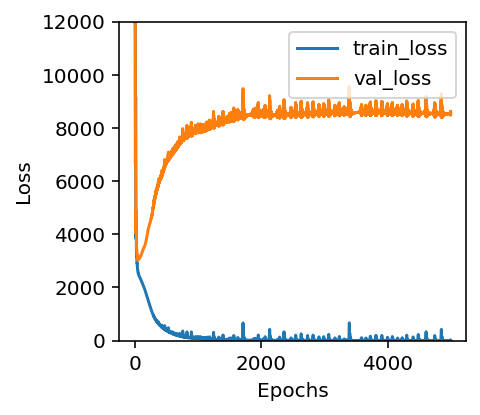

In [77]:
ncols = X.shape[1]
n_neurons = 150
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history = train1(model, X_train, X_test, y_train, y_test,
                 learning_rate=.08, nepochs=5000)

plot_history(torch.clamp(history, 0, 12000), file="train-test")

Wow. The validation error is much much worse than the training error, which is almost 0. That tells us that the model is severely overfit to the training data and is not general at all. Well, the validation error actually makes a lot of progress initially but then after a few a box immediately starts to grow (we'll use this fact later). 

### Weight decay to reduce overfitting

One of the most common ways to reduce such overfitting is to use weight decay, otherwise known as L2 (Ridge) regression, to constrain the model parameters. Without constraints, they can get very large, which typically leads to a lack of generality.  Using the `Adam` optimizer, we turn on weight decay with parameter `weight_decay`, but otherwise the training loop is the same:

In [65]:
def train2(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0, trace=True):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if trace and epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    return torch.tensor(history)

How do we know what the right value of the weight decay is?  Typically we try a variety of weight decay values and then see which one gives us the best validation error, so let's do that using a grid of images.  The following loop uses the same network and learning rate as before, but with fewer iterations since the validation error just keeps getting worse.

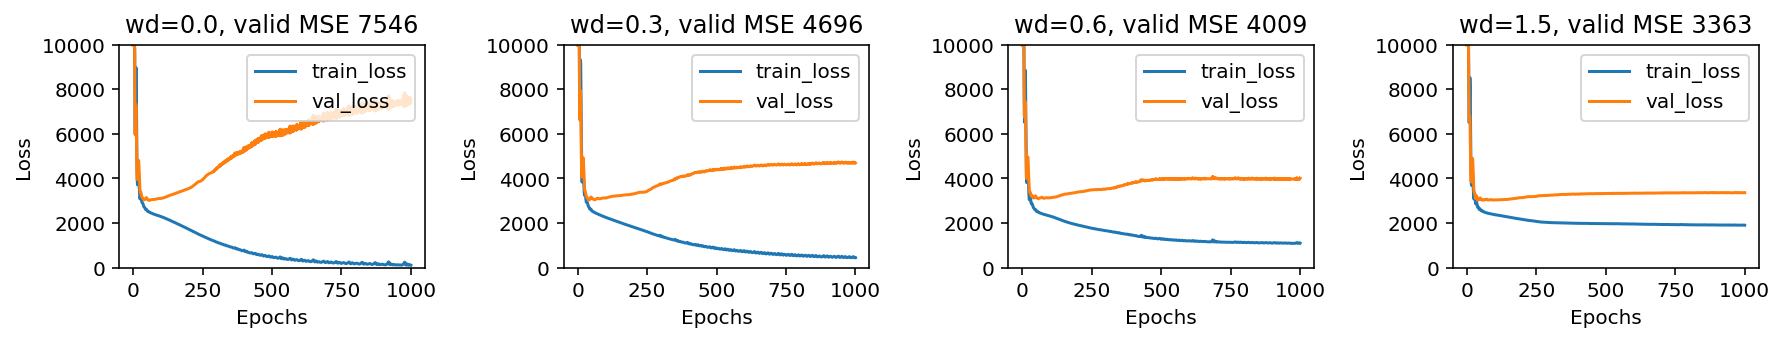

In [167]:
ncols = X.shape[1]
n_neurons = 150

fig, axes = plt.subplots(1, 4, figsize=(12.5,2.5))

for wd,ax in zip([0,.3,.6,1.5],axes):
    model = nn.Sequential(
        nn.Linear(ncols, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 1)
    )
    history = train2(model, X_train, X_test, y_train, y_test,
                     learning_rate=.08, nepochs=1000, weight_decay=wd,
                     trace=False)
    mse_valid = history[-1][1]
    ax.set_title(f"wd={wd:.1f}, valid MSE {mse_valid:.0f}")
    plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)

plt.tight_layout()
plt.show()

From this experiment, we can conclude that a weight decay of 1.5 gives the best final mean squared error. But, the experiment is reporting the final MSE all the way on the right side of the graph.

#### Exercise

Set the weight decay to something huge like 100. What do you observe about the training and validation curves?

<details>
<summary>Solution</summary>

The two curves are flat, and about the same level.  The minimum validation error is about 6000 so much worse than with more reasonable weight decay. We have seriously biased the model because we cannot even drive the training error downwards. The bias comes from the extreme constraint we've placed on the model parameters.
    
<pre>
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)
history = train2(model, X_train, X_test, y_train, y_test,
                 learning_rate=.08, nepochs=1000, weight_decay=wd,
                 trace=False)
mse_valid = history[-1][1]
ax.set_title(f"wd={wd:.1f}, valid MSE {mse_valid:.0f}")
plot_history(torch.clamp(history, 0, 10000), ax=ax, maxy=10_000)
</pre>
</details>

The minimum MSE in the above experiment (of four side-by-side graphs) appears much sooner and the validation error simply gets worse after that. That tells us that we should not pick the parameters simply as the parameters where the training leaves off. We should pick the model parameters that gives the minimum loss.  For example, let's look at the history variable that has the training and validation errors. The minimum validation error for wd=1.5 is about 2900, which is much lower than the indicated MSE on the graph:

In [86]:
torch.min(history[:,1])

tensor(2900.4353)

### Track best loss and choose best model

We saw in the previous section that the most a general model appears fairly soon in the training cycle. So, despite being able to drive the training error to zero if we keep going long enough, the most general model actually pops up very quickly after a few iterations. Let's exploit this by tracking the best model, the one with the lowest validation error. There some indication that a good approach is to (often crank up the power of the model and then) just stop early, or at least pick the model with the lowest validation error. The following function embodies that by making a copy of our neural net model when it finds an improved version.

In [67]:
def train3(model, X_train, X_test, y_train, y_test,
           learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

Let's use the exact same model and learning rate with no weight decay and see what happens.

Epoch    0 MSE train loss    29597.715   test loss    27003.609
Epoch   50 MSE train loss     2611.547   test loss     3099.683
Epoch  100 MSE train loss     2238.104   test loss     3265.314
Epoch  150 MSE train loss     1865.528   test loss     3676.546
Epoch  200 MSE train loss     1543.827   test loss     3889.615
Epoch  250 MSE train loss     1226.045   test loss     4170.277
Epoch  300 MSE train loss      964.030   test loss     4406.627
Epoch  350 MSE train loss      758.000   test loss     4748.617
Epoch  400 MSE train loss      622.150   test loss     5013.882
Epoch  450 MSE train loss      521.221   test loss     5298.492
Epoch  500 MSE train loss      464.323   test loss     5567.233
BEST MSE test loss 2965.246 at epoch 41


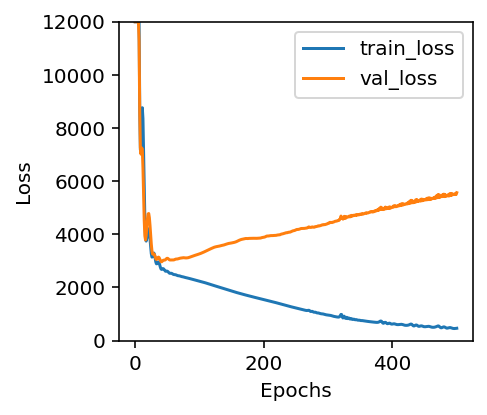

In [163]:
ncols = X.shape[1]
n_neurons = 150
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train3(model, X_train, X_test, y_train, y_test,
                             learning_rate=.08, nepochs=500,
                             weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

The best MSE bounces around 3000 from run to run, a bit above it or a bit below, depending on the run.  And this decent result occurs without having to understand or use weight decay. You might find this article interesting: [Why Deep Learning Works Even Though It Shouldn’t](https://moultano.wordpress.com/2020/10/18/why-deep-learning-works-even-though-it-shouldnt/).